In [42]:
# The code was removed by DSX for sharing.

# Analyse images on CloudObjectStorage using Mathematical Morphology methods in openCV


Mathematical Morphology (MM) is a technique based on set theory to analyse structures in images. It is different from other image processing methods in that it operates with entities like 'connected components', 'neighborhoods' or 'structural elements' as opposed to e.g. color, sharpness or frequency. Several implementations of MM exist, including the Matlab Image Processing Library and the python xxx libraries. In this notebook the python interface to the 'openCV' open source library will be used on images that reside in DSX on Cloud Object Storage.

The application presented is designed to help the barista optimize the coffee brewing process by measuring the size distribution of the coffee grind particles. The coffee brewing process is influenced by several factors, including brewing time, water pressure and temperature and the coffee grind size. The latter is mutually adjusted with the others to find the sweet spot of perfect taste for a given coffee bean roast and brewing technology (see e.g. https://www.homegrounds.co/coffee-grind-chart or https://ineedcoffee.com/coffee-grind-chart). The input data is an image of suitably prepared coffee grind taken using a low magnification microscope. MM operations including erosion, dilation, opening, closing, tophat, geodesic distance and waterfall transform are used to identify and isolate grind particles such that their size in terms of pixels can be measured.

This notebook requires a basic understanding of python and the DSX environment. Some prior knowledge about MM is required to fully understand the operations employed, but the many plots of intermediate processing results should provide a general idea of the power of a MM pipeline. No introduction to MM will be given as many good resources can be found on the web. DSX Cloud Object Storage and Data Catalog are used to store the images being analysed. The MM part of code has been developed and tested in Spider 3.2 running Python 3.6. This Jupyter Notebook has been created and run on DSX with kernel Python 3.5 and Spark 2.1 employing opencv-python Version 3.4.


## Table of Contents


## 1. Installation of python libraries and access to storage on DSX

openCV is usually not part of a python or a distribution like e.g. Anaconda, so these libs need to be installed before importing.

Access to files on IBM Cloud Object Storage (or any other cloud storage service) is different from e.g. accessing files on local hard disk in that first a connection to the storage service must be established and then the actual transfer of image data initiated. These operations require the ibm_boto3 library and credentials provided by DSX.

In the code cells below several variables and method names of default DSX provided code snippets are modified with a 'cgs' (for CoffeeGrindSieve) prefix to identify these as specific to the present notebook.

### 1.1. Installation of openCV and libraries for image processing

The Python kernel in Jupityer notebooks on DSX comes preinstalled with several common libraries. A listing is obtained by e.g. running '!pip list --format=columns' in a cell. Installation of additional libraries needs to go to user space (indicated with '--user', see code section below). The package name to use for openCV is 'opencv-python'. In case any libraries in the 'import' section below are found missing, these need to be added with a '!pip install --user ' to the cell below.

If working with e.g. Anaconda, a 'conda install -c menpo opencv3' could be used on the Linux command line.

In [43]:
!pip install --user opencv-python
#!pip install --user imageio
#!pip list --format=columns

Requirement not upgraded as not directly required: opencv-python in /home/dsxuser/.local/lib/python3.5/site-packages
Requirement not upgraded as not directly required: numpy>=1.11.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from opencv-python)


Once all libraries have been installed the following imports should be successful

In [44]:
# imports for image processing
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage import io
from mpl_toolkits.mplot3d import Axes3D

### 1.2. Insert DSX project token

Before running any actual code in a DSX Notebook a project token should be inserted for any operation that may rely on it with the following procedure

- click the icon with the three vertical dots in the DSX top right menu bar
- click 'insert project token'

This will insert a few lines of code identifying the project into the cell at the top of the notebook.

### 1.3. Access data on IBM Cloud Object Storage (COS)

Several options (including IBM Aspera, S3-compatible tools or COS Api's) exist to establish data on COS. For this example the 'upload from local disk' option in DSX will be used. The sample image can be downloaded from https://github.com/at062084/CoffeeGrindSieve/CoffeeGrindSample.jpg.

More details on how to work with COS can be found at https://medium.com/ibm-data-science-experience/working-with-ibm-cloud-object-storage-in-python-fe0ba8667d5f. The documentation to COS can be found at https://console.bluemix.net/docs/services/cloud-object-storage/about-cos.html#about-ibm-cloud-object-storage.

The following steps will upload the sample image to COS and make it available to the DSX project via the DSX Data Catalog. While using Data Catalog is not strictily necessary, it enables central administration of data assets via metadata and policy based access rules. More information on Data Catalog can be found at https://dataplatform.ibm.com/docs/content/catalog/manage-catalog.html?audience=wdp&context=analytics.

- Open a Data Catalog for the current DSX account
- Upload the sample image using the 'Add to Catalog -> Local files' option in Data Catalog
- Open the Overview page of the current DSX project
- Press the '1010' icon to add data and select the 'Catalog' option
- Select the Data Catalog employed in the previous step
- Select and add the previously uploaded sample image to the current DSX project (this also adds a connection to the Data catalog selected)

The last step will insert a 'CoffeeGrindSample.jpg' section under 'Files' in the right hand side '1010' menu bar.

### 1.4. Insert DSX credentials

A codesnippet with credentials needed to connect to the COS service is inserted into a code cell from the 'CoffeeGrindSample.jpg' section created above.

- select 'insert credentials' from the dropdown list just below 'CoffeeGrindSample.jpg'
- change the variable name of the credentials to 'cgsCreds'

The latter variable name will be used later on to actually access the sample image uploaded above. The cell containing the credentials should look like this:


In [45]:
# The code was removed by DSX for sharing.

In [46]:
# The code was removed by DSX for sharing.

## 2. Read image from Cloud Object Store

Reading files from COS is a two step process

- Establish connection to COS service
- Transfer data to processing engine

The 'ibm_boto3' library is used to support these steps.

### 2.1. Establish connection to COS

The first part is handled by inserting another code snippet, the latter is the kernel of the current notebook.

- select 'Insert streaming body object' from 'insert to code' dropdown
- rename the 'client_.....' variable to 'cgsClient' (referenced later in this notebook)
- extract the 'BUCKET' slot from the credentials into a variable named 'cgsBucket' (referenced later in this notebook)

These two will be used in a wrapper function to read files from COS into a python 'ndarray' The code cell should look like this:

In [47]:
import sys
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
cgsClient = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=cgsCreds['IBM_API_KEY_ID'],
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')
# -> 'once the ibm_api_key_id' is modified to refer to the 'cgsCreds' variable the code is safe for sharing

cgsBucket = cgsCreds['BUCKET']

type(cgsClient)

ibm_botocore.client.S3

### 2.2. Read image as stream into ndarray

The next cell offers a little convenience method to read images from a COS bucket into a python ndarray. Parts of the code as well as the comment are taken from the 'Insert streaming body object' created in the step above. It takes three input parameters:

- client: the S3 client connection created above
- bucket: the COS bucket as defined in the COS credentials above
- file: the file to connect to

In [48]:
# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about your possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/

# Method to read image from cos into numpy.ndarray
def cgsReadImage(client, bucket, file):
    isr = client.get_object(Bucket=bucket, Key=file)['Body']
    if not hasattr(isr, "__iter__"): isr.__iter__ = types.MethodType( __iter__, isr )
    return(io.imread(isr))

### 2.3. Load and show the CoffeeGrind sample image

The default size of the plotting window in DSX Jupiter notebooks is rather small, so the next cell rescales for better usability on a FullHD display. Any adjustment to the 'mpl.rcParams' will persist to the end of the current notebook.

In [49]:
cgsDefPlotSize=[12,12]
mpl.rcParams['figure.figsize'] = cgsDefPlotSize

Using the method above the sample image is loaded into memory.  The printed output gives some informtion on the image read, including size, number of color channels and data type.

This step concludes the preparation for image processing with openCV.

(2976, 3968, 3) 35426304 uint8


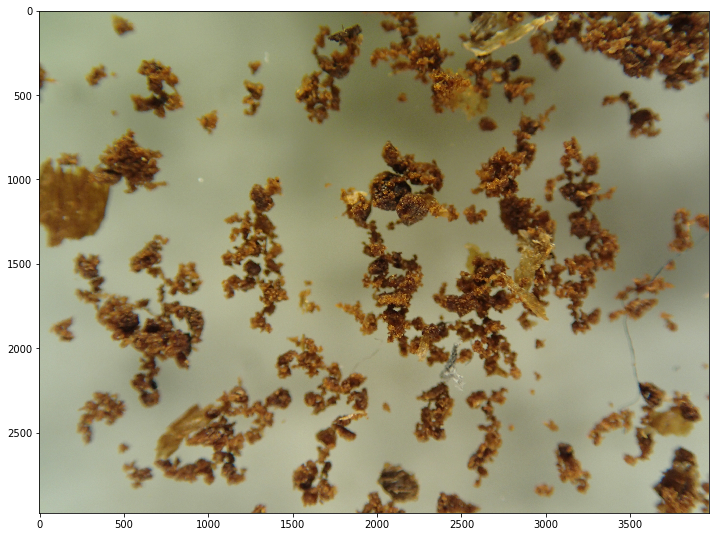

In [50]:
# pick filename from credentials
cgsImage = cgsCreds['FILE']

# read image from COS
jpg = cgsReadImage(cgsClient, cgsBucket, cgsImage)
print(jpg.shape, jpg.size, jpg.dtype)

# plot image
plt.imshow(jpg)
plt.show()

## 3. The CoffeeGrindSieve

The idea of the CoffeeGrindSieve is to take an image of the coffee grind, identify the coffee grind particles, count these and to measure their size. The final result shall be a histogram representing the distribution of the size of the particles. The distribution will be characterized in terms of mean, median and variance, indicating the size and uniformity of the coffee grind particles for a particular mill and coarseness setting.

The first part of the pipeline will identify the pixels representing coffee grind by the following steps:
- convert rgb image to graylevel using high contrast rgb channel
- flatten the background to obtain uniform lightning conditions using the MM tophat transform
- regard the graylevels of the image as levels of a Digital Elevation Model (DEM) with black representing valleys and white peaks
- convert to binary (BW) image by thresholding, with white pixels identifying coffee grind

The second part of the pipeline will identify the individual particles of the coffee grind. The challenge here is to find suitable paths to cut overlapping or otherwise cohesive particles: 
- calculate the MM geodesic distance transform of the BW image to obtain a measure of particle size as a DEM
- identify particle centers as peaks in the geodesic distance transform using the MM tophat transform
- regard the resulting pixel groups as markers for the center of the individual coffee grind particles

Finally, the pixels belonging to the individual coffee grind particles are identified and counted to obtain the distribution of the particle size:
- construct the individual coffee grind particles by growing their markers within the boundaries of the pixels identifying coffee grind (obtained in step 1)
- to do so, use the MM watershed transform to fill and seperate the basins defined by the geodesic distance transform, thereby constructing the coffee grind particles as MM connected components
- calculate the size of each connected component and etablish the distribution in terms of number of pixels

Starting from a crude image of coffee grind taken under a low magnification microscope some practical problems will be encountered requiring additional steps. These will be discussed in the upcoming sections. 


In [51]:
def imgStats(img):
    print("Image stats: ", "min:", img.min(), " max:", img.max(), " mean:", img.mean(), " median:", np.median(img))

### 3.1. Some words about MM operations --> TODO

Mathematical Morphology was initally designed to work with sets of pixels in binary (black and white, BW) images. Extensions to graylevel images have been devised, so the first step is to convert from rgb to graylevel. 

### 3.2. Convert rgb to grayscale
Several options can be used to convert from the three rgb channels to graylevel. The openCV standard method 'RGB2GRAY' calculates the graylevel as Y = 0.299\*r + 0.587\*g + 0.114\*b. Another common approach is to convert from rgb to HSV (hue, saturation, intensity) colorspace and e.g. pick the intensity channel. Here the image is split into the r,g and b channels.

The following code cell 
- splits the rgb image into its b,g,and r channels (returned in this order by openCV's 'split' method) 
- uses 'subplot' to show the b,g,r channels in a grid of one row and three cols ('subplot(nRows,nCols,curNo)')
- adapts the figure size by setting 'rcParams'
- instructs 'imshow' to use a 'gray' color map to interprete the data
- sets the dynamic range of graylevels for 'imshow' to the full 8 bit range of a graylevel jpg image


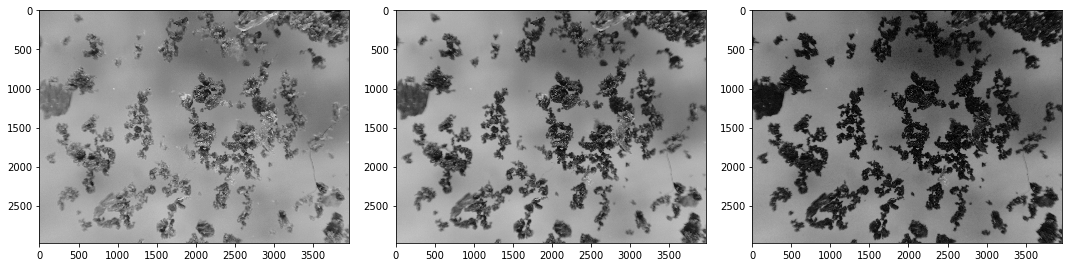

Image stats:  min: 0  max: 191  mean: 97.6831923533  median: 112.0


In [52]:
# use openCV's split method
b,g,r = cv2.split(jpg)

# use subplots to show the three color channels
mpl.rcParams['figure.figsize'] = [15,10]
plt.subplot(1,3,1); plt.imshow(b,cmap= 'gray', vmin=0, vmax=255)
plt.subplot(1,3,2); plt.imshow(g,cmap = 'gray', vmin=0, vmax=255)
plt.subplot(1,3,3); plt.imshow(r,cmap = 'gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()
mpl.rcParams['figure.figsize'] = cgsDefPlotSize

imgStats(r)

Inspection of the seperated rgb channels show that
- the blue channel is low contrast
- the green shows better contrast but in places exhibits coffee grind patches brighter than the background (e.g. top right)
- the red channel is high contrast and the coffee grind darker than the surrounding background throughout, but background lightning is uneven

The red channel is selected for further processing. The image is inverted and graylevels adjusted such that background pixels are dark and coffee grind particles bright.

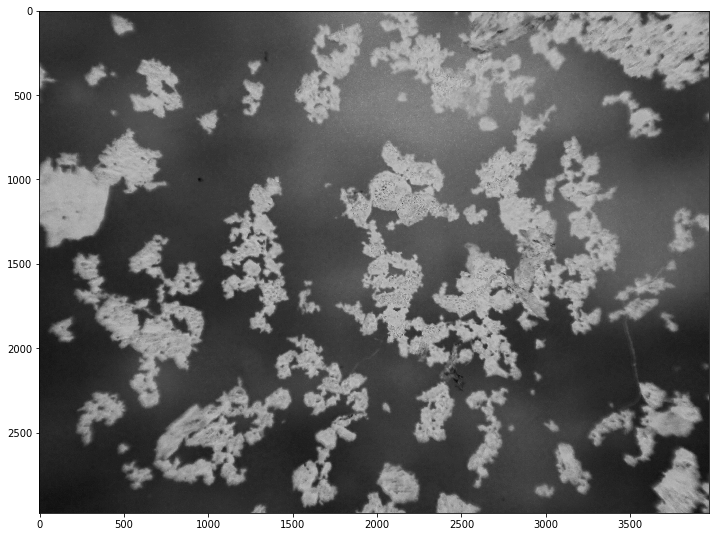

Image stats:  min: 0  max: 191  mean: 93.3168076467  median: 79.0


In [53]:
# select the red channel for further processing
gray = r
# invert
gray = 255-gray
# adjust graylevels such that the darkest pixel becomes black
gray = gray-gray.min()

plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
plt.show()
imgStats(gray)


Visual image inspection reveals some properties that need attention. Among these:

- non-uniform background lightning
- grind particles touching or partly overlaying each other
- reduced sharpness and contrast towards the edges
- some artifacts

The first two will be addressed in dedicated sections below. Sideeffects from the two others will be ignored for the purpose of this notebook.

Although openCV is implemented in C++ some operations take considerable time on large images. Thus the sample image is scaled down for fast processing. 
Size dependent parameters in subsequent operations are formulated in terms of this 'downScale' variable, so this cell is the central point to adjust the overall scaling. 

In [54]:
# downscale image by a factor downScale
downScale = 4
gray = cv2.resize(gray, None, fx=1/downScale, fy=1/downScale, interpolation = cv2.INTER_LINEAR)

print(gray.shape, gray.size, gray.dtype)
imgStats(gray)

(744, 992) 738048 uint8
Image stats:  min: 4  max: 191  mean: 93.4586598704  median: 79.0


### 3.3. The grayscale image as digital elevation model (DEM)

The graylevels of an image can be regarded as levels of a digital elevation model. This notion is at the center of the extension of MM operations from BW to gray level images: The DEM is sliced into a stack of BW images along contour lines, MM operations are applied to these individually and the resulting slices are restacked. 

The next cell presents a convenience function for a 3D DEM plot of a grayscale image, with three input parameters
- img: a grayscale image
- plotScale: a scaling parameter for the plot
- plotElev: the elevation of the viewing angle relative to the base plane.

The actual 3D plot is generated using python's plot_surface method in matplotlib. This is the one slowest operation in this notebook.

In [55]:
def cgsPlot3d(img, plotScale=1, plotElev=75):   
    # set figure size
    fig = plt.figure(figsize = (20,20))
    # downscale image to speed up plotting
    ims = cv2.resize(img, None, fx=1/plotScale, fy=1/plotScale, interpolation = cv2.INTER_LINEAR)
    # initialize 3d plot
    ax = fig.add_subplot(111, projection='3d')
    # set viewing angle
    ax.view_init(elev=plotElev)
    # create a xy grid along the size of the image
    xx, yy = np.mgrid[0:ims.shape[0], 0:ims.shape[1]]
    # construct the 3d plot on the 2D grid with z coords the gray levels
    ax.plot_surface(xx, yy, ims, rstride=1, cstride=1, cmap=plt.cm.gray, linewidth=0)
    plt.show()

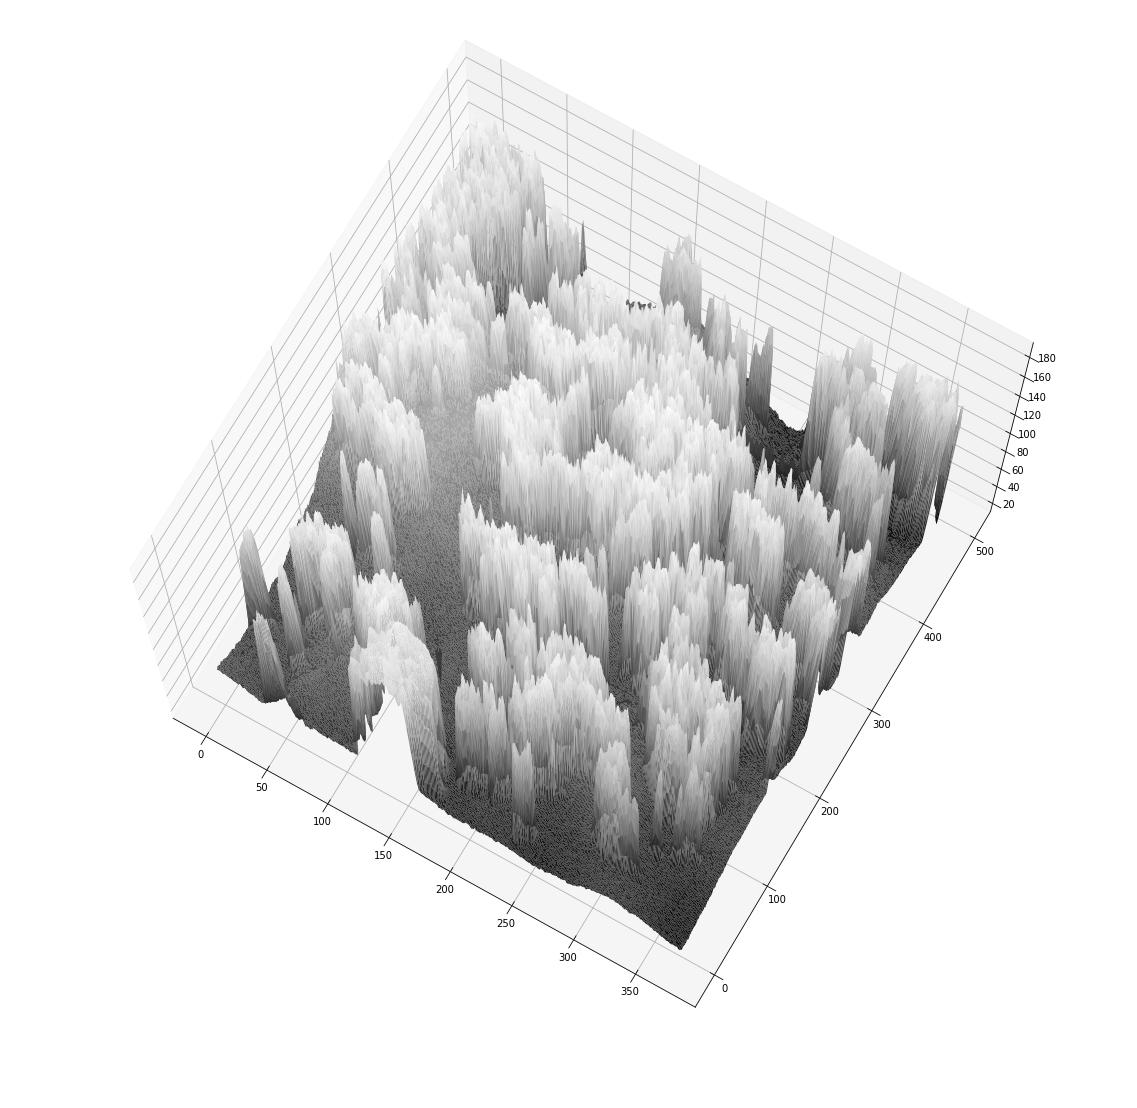

In [56]:
# plot inverted sample image (background black, coffee grind white)
cgsPlot3d(gray, plotScale=2, plotElev=75)

### 3.4. Initial image cleaning

Initial image cleaning, as all other operations in this notebook, are carried out with the grayscale image as a DEM in mind. This is the structure that MM operations actually work on. At this stage image manipulation is kept to a minimum to preserve any information while removing technical artifacts.

The openCV 'medianBlur' operation replaces each pixel with the median of it and its surroundings in an area of size 'h'. As opposed to smoothing by e.g. taking the mean, the median better preserves edges, critical in this project to identify the grind particles. Yet the operation will remove any small spikes that may result from bad pixels or lightning reflections during imaging.

This and several code cells below are headed by parameters that may be adjusted to obtain modified results. Manipulated variants of the original image are stored in dedicated variables for further reference.

The grayscale range used for plotting is explicitely set to full range for better comparison of MM operation results. As a side effect this results in low contrast for visual perception, but could easily be mitigated by setting the black and white points.

Note, however, that the minimum graylevel has changed from 0 in the (inverted and blackpoint adjusted) r channel of the original to 4 in the downsized and now 16 in the median blurred image. This points to the existence of some small dark areas ('deep valleys' in terms of a DEM) that were smeared out by the above operations. 


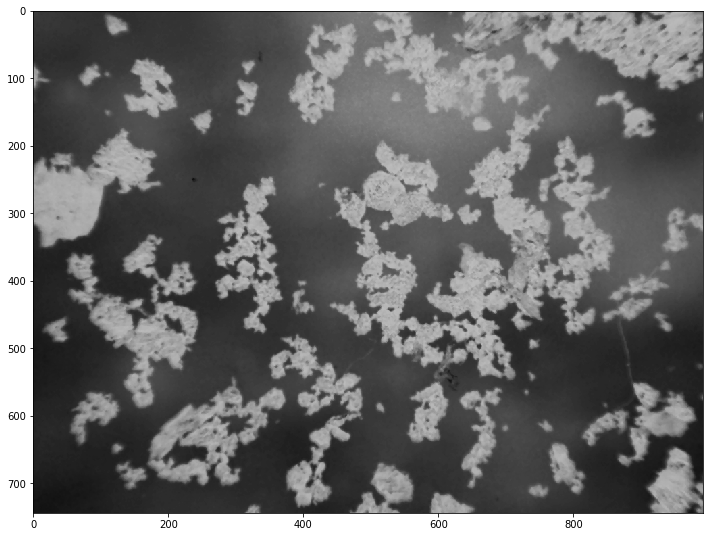

Image stats:  min: 16  max: 191  mean: 93.4614564364  median: 79.0


In [57]:
# Edge preserving smoothing
h = 3
smooth = cv2.medianBlur(gray, h)
smooth = np.uint8(smooth)
plt.imshow(smooth, cmap='gray', vmin=0, vmax=255)
plt.show()
imgStats(smooth)

### 3.5. Flatten non-uniform lightning of background

The straight forward method to identify pixels representing coffee grind particles would be to find a suitable graylevel threshold that seperates the dark coffee grind particles from the bright background into a BW image. As noted above the current image complicates the procedure in that the graylevels of the background in certain areas are in the same range as of the grind particles in other areas. Several options exist to deal with such a situation. Here the MM 'TopHat' operation will be used.

The MM 'TopHat' operation isolates and extracts 'hills' in the DEM representation of a grayscale image that have a footprint smaller than a specified size. This is accomplished by sliding a flat object (the so called 'structuring element', 'strel' or 'se') across the surface of the DEM and recording the gap between the center of the strel and the surface of the DEM for each pixel. With this approach the critical parameter is the size of the probing object, which needs to be bigger than the largest grind particle to be isolated later on. On the other hand the strel needs to be as small as possible to follow the uneven background lightning as close as possible. There are two variants of the TopHat operation:
- the 'white tophat' that extracts hills (bright) by sliding the strel across the DEM from below 
- the 'black tophat' that extracts valleys (dark) by sliding the strel across the DEM from above 

In terms of MM operations the TopHat is calculated as TopHat(img,strel) = img - Opening(img,strel). As pointed out above, in BW images the MM Opening removes structures smaller than the strel from the outscrits of a pixel group ('connected component'). This translates to estimating and removing 'hills' in graylevel images. Here the MM Opening represents the image background (as opposed to coffee grind particles).

In terms of signal processing the MM Opening and TopHat transforms can be loosely regarded as the low and high frequency components of an image, with the size of the strel a measure for the cuttoff frequency.

The size of the probing structural element is determined by experiment and choosen to be about 1/8th of the original image width. The image shows the MM TopHat transform. The uneven background lightning is mitigated. As a side effect coffee grind particles in the areas of uneven lightning are less pronounced. Note that the range of graylevels has changed from [16:191] to [0:159], and, in particular, that the median has dropped from 79 to 8, indicating that the background is now much closer to black.

For a discussion of choosing the size of the strel as 1/8 of the image size see the 'discussion' section below. Further details on the background and more refined methods of its estimation can be found in the appendix.

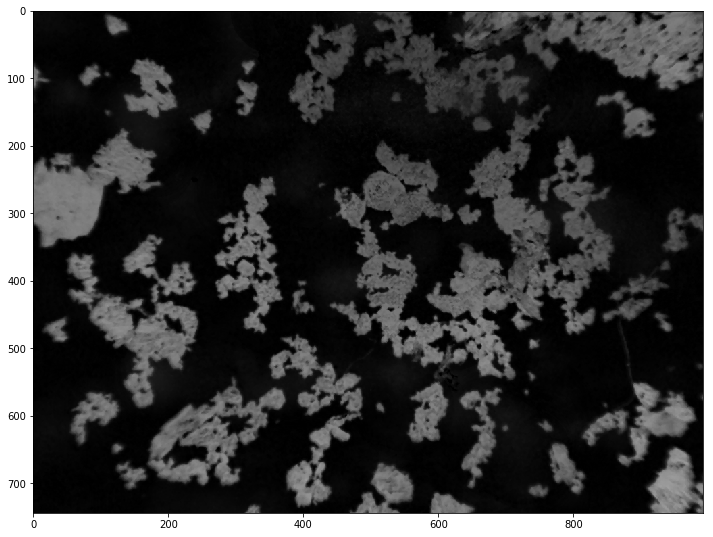

Image stats:  min: 0  max: 159  mean: 32.9588956274  median: 8.0


In [58]:
# strel size experimental --> will be 512 for original size
t=np.int(512/downScale)
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(t,t))
tophat = cv2.morphologyEx(smooth, cv2.MORPH_TOPHAT, strel)
plt.imshow(tophat, cmap='gray', vmin=0, vmax=255)
plt.show()

imgStats(tophat)

### 3.6. Classification of pixels into coffee grind and background

With background lightning flattened the coffee grind pixels are identified by applying a threshold to the DEM of the TopHat transform. A histogram of the graylevels gives an indication of possible values for the threshold. Ideally the intensity histogram would show a clear seperation between background and forground (coffeee grind) pixels. As is evident from the TopHat plot given above, no clear seperation can be expected for the sample image. Indeed, a flat minimum suggest possible thresholds between around 25 and 45. A not too low value on the lower side of this range is choosen to not pickup too many background pixels as coffee grind. Inevitably there is a tradeoff to missclassifying coffee grind pixels as background.

The histogram of graylevels is calculated using openCV's 'calcHist' method. The plot zooms into the relevant section for determination of the threshold.

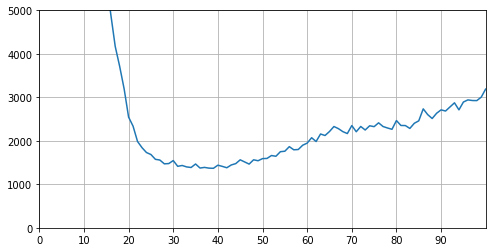

In [59]:
# Calc intensity histogram of tophat for threshold estimation
hist = cv2.calcHist([tophat],[0],None,[256],[0,256])
mpl.rcParams['figure.figsize']=[8,4]
plt.plot(hist); plt.grid()
plt.xticks(np.arange(0, 100, step=10))
plt.xlim(0,100); plt.ylim(0,5000)
plt.show()
mpl.rcParams['figure.figsize']=cgsDefPlotSize

The three plots below show the results of pixel classification for three different thresholds. As expected lower threshold values tend to classify more pixels as coffee grind, visible particularly in those areas where uneven background lightning was corrected for (see e.g. plots of top midright area below). 

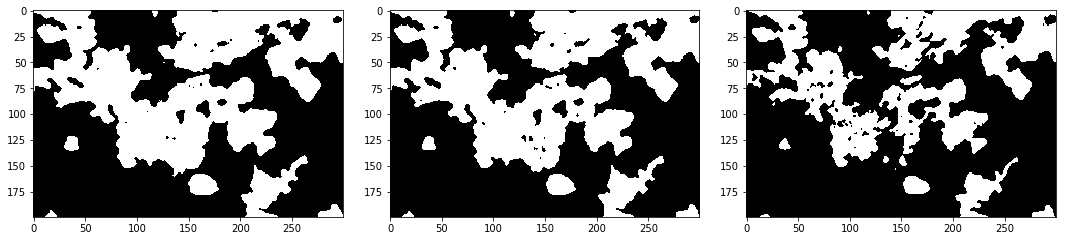

Image stats:  min: 0  max: 255  mean: 82.758011674  median: 0.0


In [60]:
# convert to BW. Threshold experimental
bw1 = cv2.threshold(tophat,28, 255, cv2.THRESH_BINARY)[1]
bw2 = cv2.threshold(tophat,32, 255, cv2.THRESH_BINARY)[1]
bw3 = cv2.threshold(tophat,48, 255, cv2.THRESH_BINARY)[1]

# use subplots to show three threshold values
mpl.rcParams['figure.figsize'] = [15,10]
plt.subplot(1,3,1); plt.imshow(bw1[0:200,500:800],cmap = 'gray')
plt.subplot(1,3,2); plt.imshow(bw2[0:200,500:800],cmap = 'gray')
plt.subplot(1,3,3); plt.imshow(bw3[0:200,500:800],cmap = 'gray')
plt.tight_layout()
plt.show()
mpl.rcParams['figure.figsize'] = cgsDefPlotSize
imgStats(bw2)


A threshold value of 32 is choosen for further processing. For remarks on this somewhat arbitrary value see the section 'discussion' below.

In [61]:
# Classify into background and coffee grind pixels
b = 32
bw = cv2.threshold(tophat,b, 255, cv2.THRESH_BINARY)[1]

### 3.7. Final classification mask

The BW image obtained is cleaned by removing very small coffee grind particles and filling very small holes. The MM methods used for this purpose are 'opening' and 'closing'. A MM opening first removes pixels from the border and then adds back pixels to the shrinked object. This removes small isolated patches and small structures at the edges. A MM closing first grows an object and then shrinks the result, thereby filling small holes and gaps ('fjords') along the circumference.

The size of the structures affected is determined by the size of the structuring element (similar to the TopHat transform). Again there is a tradeoff between removing potential artefacts introduced by the classification and retaining detail that matters.

In [62]:
# fill small holes
c=5
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(c,c))
bwc = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, strel)

In [63]:
# remove small particles
o=5
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(o,o))
bwco = cv2.morphologyEx(bwc, cv2.MORPH_OPEN, strel)

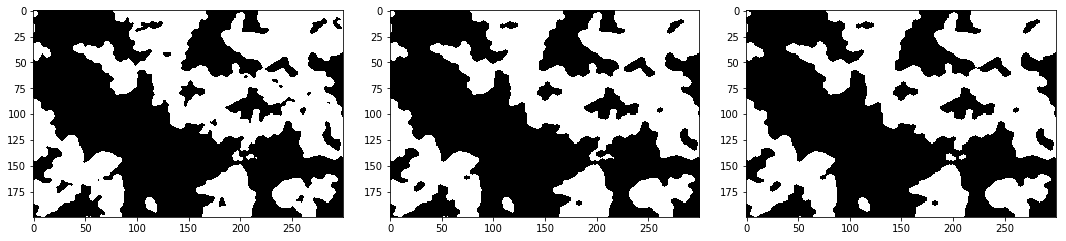

In [64]:
# Show effects of MM operations 'opening' and subsequent 'closing'
mpl.rcParams['figure.figsize'] = [15,10]
plt.subplot(1,3,1); plt.imshow(bw[400:600,400:700],cmap = 'gray')
plt.subplot(1,3,2); plt.imshow(bwc[400:600,400:700],cmap = 'gray')
plt.subplot(1,3,3); plt.imshow(bwco[400:600,400:700],cmap = 'gray')
plt.tight_layout()
plt.show()
mpl.rcParams['figure.figsize'] = cgsDefPlotSize

This step concludes the classification of pixels into coffee grind and background. The classification is used as a mask to summarize the results obtained so far. The code in the next cell calculates the classification mask as a binary matrix and applies it to the TopHat transform.

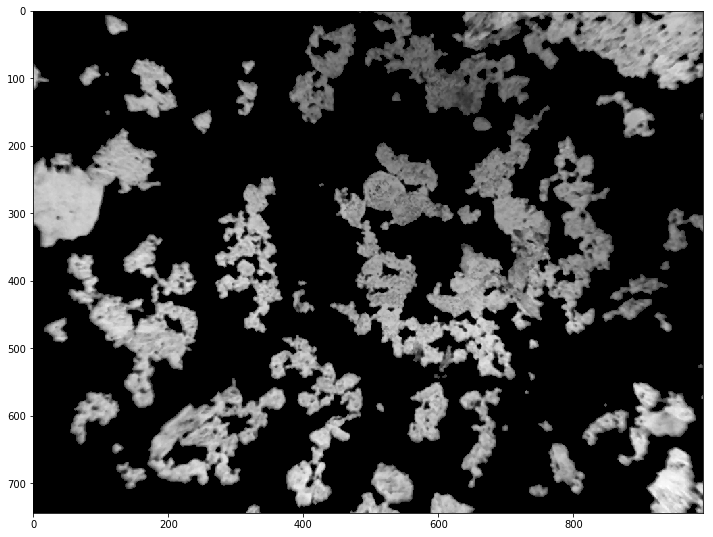

Image stats:  min: 0  max: 159  mean: 29.0357713861  median: 0.0


In [65]:
# Classification mask 
cgsMask = bwco>0
cgsImg = tophat * cgsMask
plt.imshow(cgsImg, cmap='gray')
plt.show()
imgStats(cgsImg)

### 3.8. Identification of  coffee grind particles

Ideally the next step would be to count the number of isolated white areas in the classification mask and to determine their size. Due to a lot of overlap of coffee grind particles these need to be seperated first. One method to do so is to cut the overlapping areas along constrictions, that is, along paths across narrowing cross-sections. Constrictions are identified by a local minimum of the distance from one side of a lump of coffee grind particles to the other. The MM 'geodesic distance transform' is often used as a starting point to handle distance related problems. 

The MM geodesic distance transform calculates, for every foreground pixel, the distance to the nearest background pixel. Interpreting the result as a DEM, the elevation increases towards the center of foreground objects, with the center itself a local peak. Constrictions are identified by local minima (saddle points) along the DEM's ridges.

The following plot shows the geodesic distance transform for the classification mask calculated in the previous step. The parameters to the distance transform determine the algorithm to calculate the distance from the nearest background pixel. The elevation is transformed with a square root to visually enhance areas of low geodesic distance, that is, pixels near the edge of coffee grind particles.

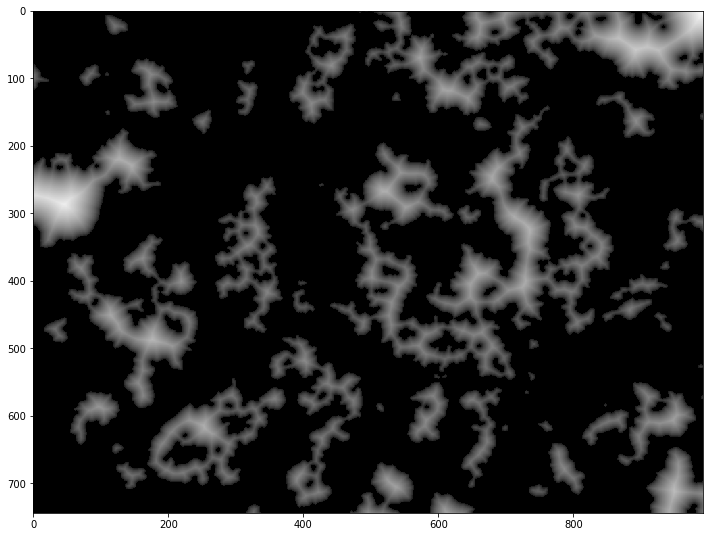

Image stats:  min: 0.0  max: 255.0  mean: 11.5666  median: 0.0


In [66]:
# distanceTransform
msk = np.uint8(cgsMask)
dt = cv2.distanceTransform(msk, distanceType=cv2.DIST_L2, maskSize=cv2.DIST_MASK_PRECISE)
plt.imshow(np.sqrt(dt/dt.max())*255, cmap='gray', vmin=0, vmax=255)
plt.show()
imgStats(dt/dt.max()*255)

Interpreting the distance transform as a DEM, the hills will have a slope of not higher than and predominantly around 45 deg (the DEM height increases identical to the distance from the background). A TopHat transform with an even numer of pixels sized strel can be used to favorably visualize this peculiar DEM.

[[0 1]
 [1 1]]


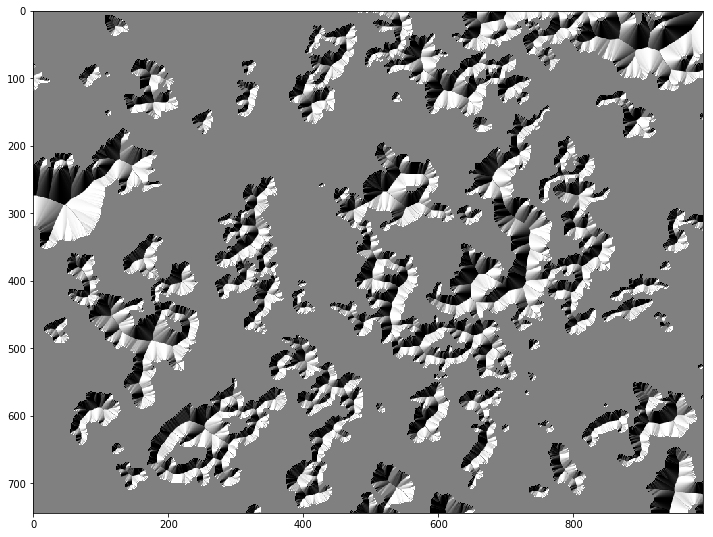

Image stats:  min: -1.0  max: 1.0  mean: 0.00218095  median: 0.0


In [67]:
t=2
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(t,t))
print(strel)
th2 = cv2.morphologyEx(dt, cv2.MORPH_BLACKHAT, strel)
plt.imshow(th2, cmap='gray')
plt.show()
imgStats(th2)

This last image suggests that there are at least two options to isolate the coffee grind particles starting from the geodesic distance transform
- cut along constrictions (with the width of the constriction a threshold)
- identify the centers of coffee grind particles as its peaks (with the height of the peaks a threshold)

The results will be different depending on the method used and the setting of the threshold parameters. For the purpose of this notebook the peaks in the DEM with a minimal elevation will be used to identify the centers of the coffee  grind particles. As will become evident in the next section, these peaks can be used as 'seeds' to grow the actual coffee grind particles.

Because the MM 'Local Minima' method is not implemented in openCV, the 'skyimage' morphology library is employed here.
- the 'h_maxima' method extracts the peaks of at least height 'h'
- the 'connectedComponents' method counts the number of peaks of a given height (corresponding to number of particles of minimum size)

Remark: In the field of 'Granulometry' this kind of 'number of objects vs. size of object constructor' relation is used to infere the size of objects in an image.

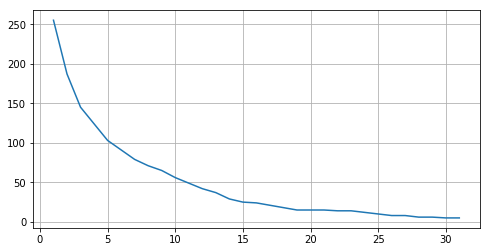

In [68]:
# Find local maxima in dt DEM
from skimage import morphology as sm

t=3
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(t,t))
c=[]
for h in range(1,32):
    mxa = sm.h_maxima(dt,h,strel)
    n,cc = cv2.connectedComponents(np.uint8(mxa>0))  
    c.append(n)
      
mpl.rcParams['figure.figsize']=[8,4]
plt.plot(range(1,32),c)
plt.grid()
plt.show()
mpl.rcParams['figure.figsize']=cgsDefPlotSize


A minimum elevation of the peaks (local maxima) of 2 above its surroundings is selected for further processing. Again, this decision is discussed further in the section 'discussion' below. The next image shows the coffee grind with the classification mask applied and the local maxima of the distance transform indicated as black dots.

Number of coffee grind particles: 187


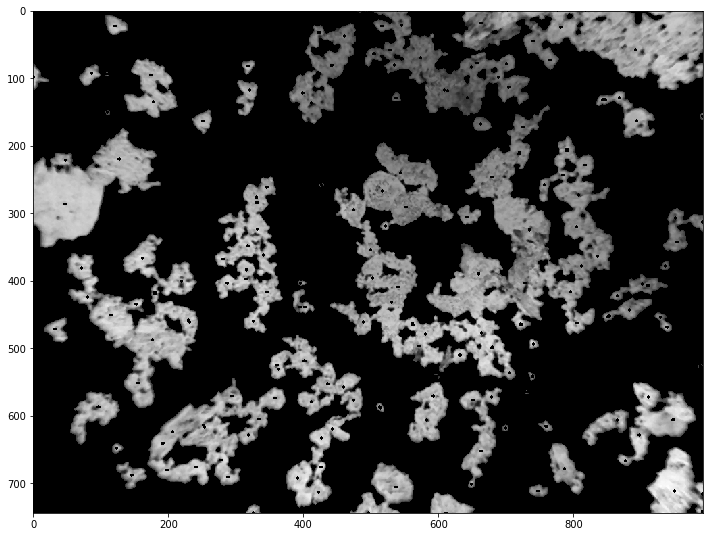

Image stats:  min: 0  max: 1  mean: 0.00444957509539  median: 0.0


In [69]:
# Show local maxima found in distance transform of classification mask
t=3
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(t,t))

# calculate local maxima
h=2
seeds = sm.h_maxima(dt,h,strel)
seeds = np.uint8(seeds)

# count and identify local maxima as connected components
n,cc = cv2.connectedComponents(seeds)  
print("Number of coffee grind particles:", n)

# grow markers for visual clarity
t=5
strel5 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(t,t))
markers = cv2.morphologyEx(seeds, cv2.MORPH_DILATE, strel5)

# plot markers as black dots on top of the coffee grind
plt.imshow(cgsImg * (1-markers), cmap='gray')
plt.show()
imgStats(markers)

### 3.9. Using the watershed transform to segment the coffe grind particles

The watershed transform is a method used in the field of image segmentation. Essentially it starts from basins defined by the local minima of an image and poors water into these basins until one is about to overflow into a neighbouring basin. To prevent doing so, walls are built up at the location where overflow would occure. The process ends when all basins have been filled and all walls built. In many cases this leads to oversegmentation (each little minimum in the DEM generates one basin, that is, segment).

One common strategy to mitigate oversegmentation is to identify the initial basins by excplicitely providing starting points instead of automatic calculation as DEM local minima. For the segmentation of the coffee grind particles it is exactly the seeds calculated above (as local maxima of the distance transform of the coffe grind classification matrix) that are the desired watershed starting points

The following code cell
- calculates the watershed transform of the masked coffee grind image from these starting points
- segments built during watershed have their pixel's intensity value set to the segment number
- walls built during watershed are set to -1, so 1 is added to obtain a valid graylevel image range
- increases the thickness of walls for visaul clarity (in fact, the actual segments are shrinked with an MM erode operation leaving a thicker wall between them)

Remark: For some reason, the image background is listed as just another segment in the watershed transform. The corresponding segment number is calculated as the most frequent graylevel value and subsequently set to zero.

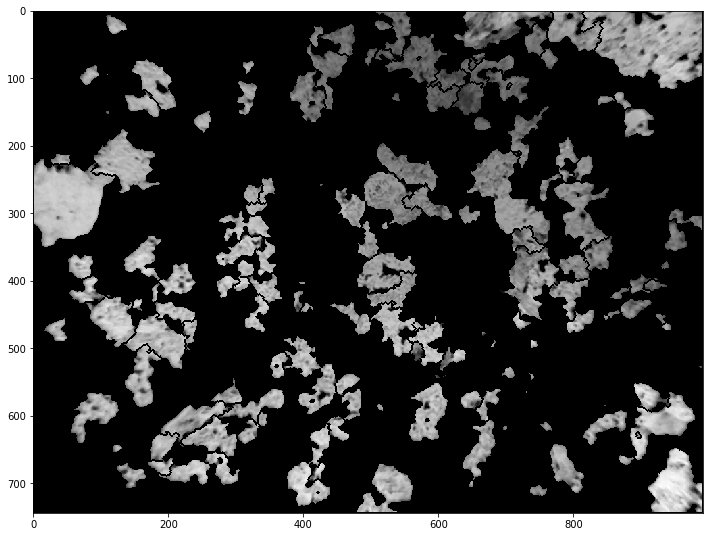

In [70]:
# must convert to rgb image for watershed
rgb = cv2.cvtColor(cgsImg, cv2.COLOR_GRAY2BGR)
# Run watershed. Walls are identifed as '-1'. 
ws = cv2.watershed(rgb,cc)+1
ws = np.uint8(ws)

# set image background to 0. don't know why background is just another segment
hist = cv2.calcHist([ws],[0],None,[256],[0,256])
idx = np.argmax(hist)
ws[ws==idx] = 0

# increase size of segmentation walls for visual clarity
t=3
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(t,t))
wsd = cv2.morphologyEx(ws, cv2.MORPH_ERODE, strel)

# plot black segmentation walls on top of the coffee grind
cgs = (wsd>1)*cgsImg
plt.imshow(cgs, cmap='gray')
plt.show()

### 3.10. Calculate size of coffee grind particles

The only thing left to do is to calculate the size of the segmented coffee grind particles. Here a variant of the openCV 'connectedComponents' method is used that returns the size of the components in 'cc_stats'. 

In [71]:
# Final connected components
cc_n, cc_lbl, cc_stats, cc_cntr = cv2.connectedComponentsWithStats(ws, connectivity=4)

From a coffee brewing perspective the diameter of the coffee grind particles is the important parameter. Thus the final values are calculated as square root of the size in pixels. For absolute values in units of e.g. millimeters the area an image pixel covers in object space needs to be provided.

The following convenience method creates the histogram with suiteable x and y tics as well as labels.

In [72]:
def ccHist(cc):
    m=126; k=5; n = np.uint8(m/k)
    x = np.double(range(0,m,k))
    h = np.histogram(cc, bins=x**2)
    mpl.rcParams['figure.figsize']=[12,6]
    fig = plt.figure()
    plt.bar(x[0:n]+k/2,h[0][0:n],k-1)
    plt.xticks(np.uint8(x),np.uint8(x))
    plt.grid(); plt.xlim(0,m-1)
    plt.title("openCV-CoffeeGrindSieve")
    plt.xlabel("Mean diameter of particles [~pixels]")
    plt.ylabel("Number of particles")
    plt.show()
    mpl.rcParams['figure.figsize']=cgsDefPlotSize
    

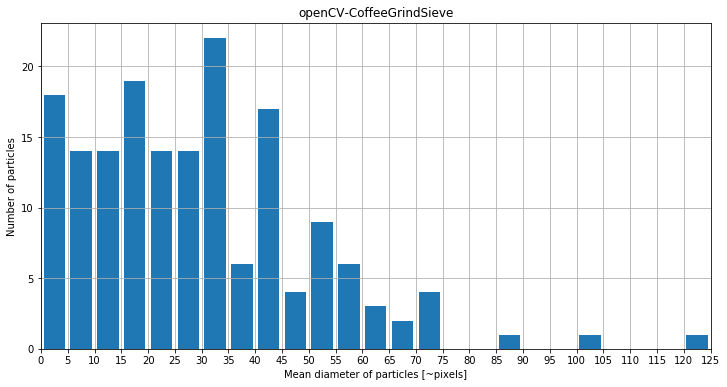

In [73]:
# Area of cc's
cc_area = cc_stats[:,cv2.CC_STAT_AREA]
ccHist(cc_area)

In [74]:
cc_diameter = np.sqrt(cc_area)
print("MeanDiameter=%d+-%d    MedianDiameter=%d IQR=%d" % 
      (np.mean(cc_diameter), np.std(cc_diameter), np.median(cc_diameter), np.percentile(cc_diameter,75)-np.percentile(cc_diameter,25)))

MeanDiameter=33+-56    MedianDiameter=26 IQR=27


## 4. Discussion and outlook

### 4.1. Critical parameters
All MM methods require a structuring element for their operation, with the size a critical parameter. Either a fixed setting or an automatic estimation is needed for a production grade pipeline. The present notebook makes manual assumptions on MM and other parameters in several places that need elaboration. Among these

- the approach to convert from color to grayscale
- the size of the structuring element for flattening the uneven lightning of the image back ground
- the graylevel threshold value to seperate coffee grind from background
- the algorithm and parameters to seperate overlapping coffee grind particles

### 4.2. Image acquistion process
For the most part the first three challenges can be eliminated by a suitable setup of the image acquistion process. Uniform lightning, optimized light color and direction, optimized image back ground, flat focal plane asf. contribute to consistent results.

The problem of segmentation of coffee grind into particles is different in that 
- the algorithm choosen (e.g. local maxima or constrictions of the distance transform) yields different results
- it is not obvious what the correct result looks like in the first place

In particular it is not obvious what constitutes a coffee grind particle in the presence of overlap or otherwise cohesive coffee grind. The amount of particle overlap should, as above, be controlled before image acquisition. The remaining ambiguity inevitably leads to some imponderability of the final result. For a series of measurements with identical parameters these amount to a calibration of the image processing pipeline. The results should be comparable but not necessarily optimal.

### 4.3. Advanced segmentation
Close inspection of the final segmentation result shows patches of coffee grind that have been seperated while others remain connected, both for no obvious reason. More work is needed to investigate this behavior. To this end several elaborate MM methods exist, including e.g. skeletons or geodesic reconstruction. These could be written based on the MM operations available in openCV, but are not readily available (yet). Another resource of morphological methods in python is the morphology library of the skyimage package.




## 5. Summary

The Mathematical Morphology methods in the openCV (openComputerVision) library have been successfully applied in the CoffeeGrindSieve image segmentation application. The application was developed as a python notebook residing on IBM DataScienceExperience (DSX), with data located on IBM Cloud Object Storage (COS). 

### 5.1. References
- openCV documentation
- skyimage morphology documentation
- ibm_boto3 documentation
- IBM WatsonDataPlatform Data Catalog documentation

### 5.2. About the Author

